# Project questions:

# Distributed Data Infrastructures, Fall 2020, Project 2

Assignment
In this project, you are supposed to use GraphLab to analyze data sets. GraphLab is a high performance, open-source, big data framework which we have discussed in the course. We provide you with a data set and you should run GraphLab either on AWS or locally to analyze the data set. 

The dataset was released by Telecom Italia for their Open Big Data Challenge in 2014. It contains telecommunication records, weather, air quality, electricity consumption for city of Milan and province of Trentino in Italy in November and December 2013. You can find detailed description of the dataset from the paper:
https://www.nature.com/articles/sdata201555.

Requirements
You need write a program that uses GraphLab to provide answers to the following questions.

### First three questions are worth 2 points total.

1. Find the most congested communication period of the day in Milan and Trentino.

2. List top 5 Italian provinces which are most called by residents of Milan and Trentino on average.

3. List top 5 languages tweeted by distinct users in Milan. How popular is Finnish as a tweeting language in Milan?

### The following questions are worth 3 points total.

4. Compare call and internet activity between 24th, 25th and 26th December to 26th, 27th, 28th November for Milan. Plot the distribution.

5. Find correlation between user communication activity and different weather conditions (e.g. rain, snow etc.) in Milan and Trentino.

### The final questions are worth 2 points each.

6. Plot the heatmap of user telecommunication activity for both Milan and Trentino. Do you observe any shift in communication pattern of users between day and night? (A typical day time is between 8AM to 8PM)

7. Investigate and plot the correlation between air quality and weather (temperature, sunshine, precipitation, etc.).

### Read libraries

In [214]:
import pandas as pd
from turicreate import SFrame, SGraph, Vertex, Edge
import arrow
import glob2
import time
from datetime import datetime as dt
import turicreate.aggregate as agg
import matplotlib.pyplot as plt

## 1. Find the most congested communication period of the day in Milan and Trentino.

Answer to this question based on the telecommunication data for Milan and Trentino on 24th December 2013. Answer will be the most congested hour in the given day.

#### Telecommunication data has folllowing information:

0. Square id: identification string of a given square of Milan/Trentino GRID;

1. Time Interval: start interval time expressed in milliseconds. The end interval time can be obtained by adding 600,000 milliseconds (10 min) to this value;

2. Country code: the phone country code of the nation.

3. SMS-in activity: activity proportional to the amount of received SMSs inside a given Square id and during a given Time interval. The SMSs are sent from the nation identified by the Country code.

4. SMS-out activity: activity proportional to the amount of sent SMSs inside a given Square id during a given Time interval. The SMSs are received in the nation identified by the Country code;

5. Call-in activity: activity proportional to the amount of received calls inside the Square id during a given Time interval. The calls are issued from the nation identified by the Country code;

6. Call-out activity: activity proportional to the amount of issued calls inside a given Square id during a given Time interval. The calls are received in the nation identified by the Country code;

7. Internet traffic activity: number of CDRs generated inside a given Square id during a given Time interval. The Internet traffic is initiated from the nation identified by the Country code;

In [95]:
# Define function to find peak hour for the day
def peak_n_hours(sframe, n):
    # Add hour column
    sframe['hour'] = sframe['Time'].apply(lambda t: dt.utcfromtimestamp(t/1e3).strftime('%H'))
    
    # Calculate hourly activity
    sf_hourly = sframe.groupby(key_column_names = 'hour', operations= {'smsin':agg.SUM('SMSin'), 
                            'smsout': agg.SUM('SMSout'), 'callin':agg.SUM('call_in'),
                            'callout': agg.SUM('call_out'), 'int_traffic': agg.SUM('internet_traffic')})
    
    # Calculate sum of the activity volumns
    sf_hourly['total'] = sf_hourly['smsin']+sf_hourly['smsout']+sf_hourly['callin']+sf_hourly['callout']+sf_hourly['int_traffic']
    
    # Drop other columns except hour and total
    sf = sf_hourly["hour", "total"]
    
    # Sort sf_hourly and fet 5 largest values
    sf = sf.sort('total', ascending=False)
    
    # Return n first hours and their total activity
    return sf.head(n)

In [94]:
# Set path to files
milano_dec24_path = 'data/milano_telecom_dec/sms-call-internet-mi-2013-12-14.txt'
trentino_dec24_path = 'data/trento_telecom_dec/sms-call-internet-tn-2013-12-14.txt'

# Read the files. SFrame is not able to handle rows with different lengths, 
# so first read data with pandas and then convert to SFrame
milano = pd.read_csv(milano_dec24_path, sep="\t", header=None).fillna(0)
milano = SFrame(milano)
trentino = pd.read_csv(trentino_dec24_path, sep="\t", header=None).fillna(0)
trentino = SFrame(trentino)

# Add column names to SFrames
milano = milano.rename({'0': 'SquareID', '1':'Time', '2':"country_code", "3":"SMSin", "4":"SMSout", "5":"call_in" , "6":"call_out", "7":"internet_traffic"})
trentino = trentino.rename({'0': 'SquareID', '1':'Time', '2':"country_code", "3":"SMSin", "4":"SMSout", "5":"call_in" , "6":"call_out", "7":"internet_traffic"})

# Run function and print n=5 busiest communication hours
print("The most congested communication hours of the 24th Dec 2013 in Milan")
print(peak_n_hours(milano, 5))
print("The most congested communication hours of the 24th Dec 2013 in Trentino")
print(peak_n_hours(trentino, 5))


The most congested communication hours of the 24th Dec 2013 in Milan
+------+--------------------+
| hour |       total        |
+------+--------------------+
|  16  | 5416257.583677525  |
|  11  | 5371330.078746552  |
|  17  | 5344031.796636853  |
|  10  | 5337831.3245685985 |
|  15  | 5284227.558210128  |
+------+--------------------+
[5 rows x 2 columns]

The most congested communication hours of the 24th Dec 2013 in Trentino
+------+--------------------+
| hour |       total        |
+------+--------------------+
|  16  | 1036600.3784612623 |
|  10  | 1029579.4795295165 |
|  17  | 1011900.8027854263 |
|  11  | 1007262.7792211826 |
|  15  | 1006217.552276318  |
+------+--------------------+
[5 rows x 2 columns]



## 2. List top 5 Italian provinces which are most called by residents of Milan and Trentino on average.

I will answer to this question based on the "Milan/trentino to provinces" telecommunication dataset on 24th December 2013.

Milan/trentino to provinces dataset has following columns:

0. Square id: identification string of a given square of Milan/Trentino GRID;

1. Time Interval: Start interval time expressed in milliseconds. The end interval time can be obtained by adding 600,000 milliseconds (10 min) to this value;

2. Square to Province Inter: Value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Square id, and receivers located in the Province;

3. Province to Square Inter: Value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Province, and receivers located in the Square id.

4. Province: the name of the Italian province.

In [109]:
def most_called_provinces(sframe):
    # Rename columns
    sframe = sframe.rename({'0': 'SquareID', '1':'Province', '2':"Time", "3":"SqrtToProvince", "4":"ProvinceToSqrt"})
    
    # Drop columns where ProvinceToSqrt=0. These rows are incoming calls from provinces 
    # and we want only count calls to provinces.
    sframe = sframe[sframe["SqrtToProvince"] > 0]
    
    # Count by provinces
    famous_prov = sframe.groupby(key_column_names = 'Province', operations= {'count': agg.COUNT()})
    
    # Sort by count and return top5 provinces
    return famous_prov.sort('count', ascending=False).head(5)


In [110]:
# Set path to files
milano_dec24_path = 'data/milano_provinces_telecom/mi-to-provinces-2013-12-24.txt'
trentino_dec24_path = 'data/trento_provinces_dec/tn-to-provinces-2013-12-24.txt'

# Read the files. SFrame is not able to handle rows with different lengths, 
# so first read data with pandas and then convert to SFrame
milano = pd.read_csv(milano_dec24_path, sep="\t", header=None).fillna(0)
milano = SFrame(milano)
trentino = pd.read_csv(trentino_dec24_path, sep="\t", header=None).fillna(0)
trentino = SFrame(trentino)

# Run function and print top 5 provinces most called by residents
print("The most called provinces from Milano on the 24th Dec 2013")
print(most_called_provinces(milano))
print("The most called provinces from Trentino on the 24th Dec 2013")
print(most_called_provinces(trentino))


The most called provinces from Milano on the 24th Dec 2013
+-----------------------+--------+
|        Province       | count  |
+-----------------------+--------+
|         MILANO        | 970483 |
| MONZA E DELLA BRIANZA | 217406 |
|         PAVIA         | 175663 |
|         VARESE        | 85739  |
|         NAPOLI        | 84398  |
+-----------------------+--------+
[5 rows x 2 columns]

The most called provinces from Trentino on the 24th Dec 2013
+---------------+--------+
|    Province   | count  |
+---------------+--------+
|     TRENTO    | 527030 |
| BOLZANO/BOZEN | 107719 |
|    BRESCIA    | 80951  |
|     VERONA    | 59680  |
|     MILANO    | 54876  |
+---------------+--------+
[5 rows x 2 columns]



## 3. List top 5 languages tweeted by distinct users in Milan. How popular is Finnish as a tweeting language in Milan?

The SocialPulse dataset [Data citations 10,11] contains geolocalized tweets originated from Milan between November 1, 2013 and January 1st, 2014.

0. user: anonymized Twitter username;

1. language: language of the Tweet, where und means undefined;

2. municipality: the municipality in which the tweet has been probably created. The approximation is the same of the geometry field (see below). The municipality field is composed of the municipality name and the Dandelion acheneID, specified in the Administrative Regions dataset. Users can get more data about the municipality (e.g., boundaries, population) using the acheneID as a primary key in the Administrative Regions;

3. timestamp: Tweet timestamp;

4. geometry latitude: approximate position of the tweet, in geoJSON format. Error <600 m.

5. geometry longitude: approximate position of the tweet, in geoJSON format. Error <600 m.

In [121]:
# Set path to file
milano_path = 'data/social_pulse/social_pulse_milano.csv'

# Read the files
milano = SFrame.read_csv(milano_path, sep="\t", header=None)

# Rename columns
milano = milano.rename({'X1': 'user', 'X2':'language', 'X3':"municipality", "X4":"timestamp", "X5":"latitude", "X6":"longitude"})
    
# Count language
languages_count = milano.groupby(key_column_names = 'language', operations= {'count': agg.COUNT()})

# Sort languages by count
languages_count = languages_count.sort('count', ascending=False)

# Print 15 most populat tweeting languages
languages_count.print_rows(num_rows=15)

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/social_pulse/social_pulse_milano.csv

Parsing completed. Parsed 100 lines in 0.18057 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,int,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/social_pulse/social_pulse_milano.csv

Parsing completed. Parsed 269290 lines in 0.169974 secs.

+----------+--------+
| language | count  |
+----------+--------+
|    it    | 163889 |
|    en    | 47830  |
|    es    |  7745  |
|    tl    |  6815  |
|    pt    |  5162  |
|    so    |  4013  |
|    fr    |  3654  |
|    id    |  3183  |
|   und    |  3132  |
|    de    |  2183  |
|    tr    |  2065  |
|    ar    |  1886  |
|    nl    |  1754  |
|    ro    |  1746  |
|    fi    |  1594  |
+----------+--------+
[45 rows x 2 columns]



## 4. Compare call and internet activity between 24th, 25th and 26th December to 26th, 27th, 28th November for Milan. Plot the distribution.

To answer this question, I will calculate hourly call and internet activity for each day, and then make histogram of hourly activities in given days in November and December.

In [405]:
def create_hourly_telecom_SFrame(paths, start_date, end_date):
    # Measure time how long it takes. Set start time.
    start = time.time()
    
    # Filter paths by start_date and end_date
    # Path example: sms-call-internet-mi-2013-12-01.txt
    wanted_paths = []
    for path in data_paths:
        date = int(path[-6:-4])
        if (date <= end_date) and (date >= start_date):
            wanted_paths.append(path)
    
    # Read the files and append dataframes to result_df
    result_df = pd.DataFrame(columns = ["day", "SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "internet_traffic"])
    for path in wanted_paths:
        day = path[-6:-4]
        df = pd.read_csv(path, sep="\t", header=None)
        df = df.fillna(0)
        df.columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "internet_traffic"]
        df["day"] = day
        result_df= result_df.append(df)
    
    # Convert Pandas dataframe to SFrame
    sf = SFrame(data=result_df)
    
    # Drop columns SquareID and country_code
    sf = sf.remove_column('SquareID')
    sf = sf.remove_column('country_code')
    
    # Add hour column and add 1 hour to time (from UTC to Rome time)
    sf["hour"] = sf["Time"].apply(lambda timestamp: arrow.get(timestamp+3600000).format('HH'))

    # Group by day and hour, and sum of each activity in each hour and day
    sf_hourly = sf.groupby(['day', 'hour'], {'callin':agg.SUM('call_in'), 
                                             'callout': agg.SUM('call_out'), 
                                             'int_traffic': agg.SUM('internet_traffic')})
    
    # Calculate sum of callin and callout
    sf_hourly["calls"] = sf_hourly["callin"]+sf_hourly["callout"]
    
    # Drop columns SquareID and country_code
    sf_hourly = sf_hourly.remove_column('callin')
    sf_hourly = sf_hourly.remove_column('callout')
    
    # Sort by day and hour
    sf_hourly = sf_hourly.sort(['day', 'hour'], ascending=True)
    
    # Set hour and day type to int
    sf_hourly["day"] = sf_hourly["day"].astype(int)
    sf_hourly["hour"] = sf_hourly["hour"].astype(int)
    
    # Print time how long it took
    end = time.time()
    print("Time to run function was", round(end - start), "seconds")

    # Return results
    return sf_hourly


In [406]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_milano_dec = glob2.glob("data/milano_telecom_dec/*")

# Use create_telecom_SFrame to read paths and join the files within given dates
milano_nov = create_hourly_telecom_SFrame(data_paths_milano_nov, 26, 28)
milano_dec = create_hourly_telecom_SFrame(data_paths_milano_dec, 24, 26)

# Print first 5 rows
milano_nov.print_rows(num_rows=5)
milano_dec.print_rows(num_rows=5)

Time to run function was 91 seconds
Time to run function was 85 seconds
+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  26 |  0   | 3081805.377790227  | 41192.73183245976  |
|  26 |  1   | 2572701.778685306  | 17706.488070584168 |
|  26 |  2   | 2231849.134087163  | 11778.291443263011 |
|  26 |  3   | 2032399.1755711315 | 10178.701211725682 |
|  26 |  4   | 1922521.8709400008 | 11383.31819981833  |
+-----+------+--------------------+--------------------+
[72 rows x 4 columns]

+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  24 |  0   | 3688771.5463870503 | 85336.24936358447  |
|  24 |  1   | 3129452.0027063154 | 47241.110215355206 |
|  24 |  2   |  2618230.29904727  | 26772.50274999522  |
|  24 |  3   | 2293036.6762779923 | 19610.40673445

In [402]:
# Make histograms
def make_histograms(SFrame, title):    
    # Plot the distibution (make histograms)
    fig, ax = plt.subplots(2, 1, sharey=True, tight_layout=True)
    ax[0].hist(SFrame["calls"], bins=50)
    ax[0].title.set_text('Calls traffic distibution {}'.format(title))
    ax[1].hist(SFrame["int_traffic"], bins=50)
    ax[1].title.set_text('Internet traffic distibution {}'.format(title))
    plt.show()
    
    # Make days list and sort it
    days = list(SFrame["day"].unique())
    days = sorted(days)
    
    # Make hourly calls graph. Add vertical lines to 8am and 8pm
    for day in days:
        sf_day = SFrame[SFrame["day"] == day]
        plt.plot(sf_day["hour"], sf_day["calls"])
        plt.axvline(x=8, color='gray', linestyle='--', lw=1)
        plt.axvline(x=20, color='gray', linestyle='--', lw=1)
    plt.title('Hourly calls activity {}'.format(title))
    plt.legend([days[0], days[1], days[2]], loc ="upper left") 
    plt.show()
 
    # Make hourly internet activity graph
    for day in days:
        sf_day = SFrame[SFrame["day"] == day]
        plt.plot(sf_day["hour"], sf_day["int_traffic"])
        plt.axvline(x=8, color='gray', linestyle='--', lw=1)
        plt.axvline(x=20, color='gray', linestyle='--', lw=1)
    plt.title('Hourly internet activity {}'.format(title))
    plt.legend([days[0], days[1], days[2]], loc ="upper left") 
    plt.show()

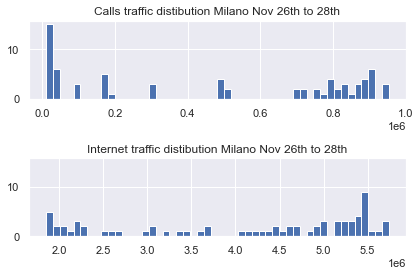

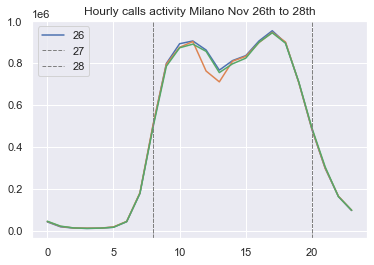

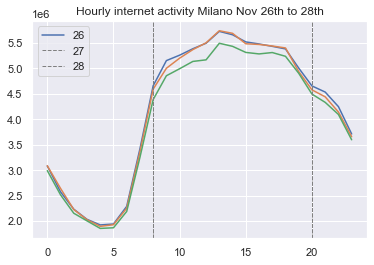

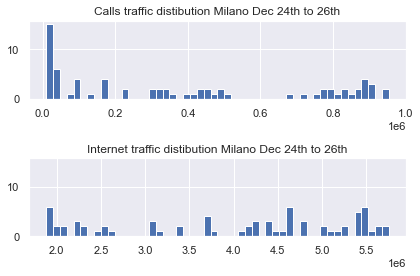

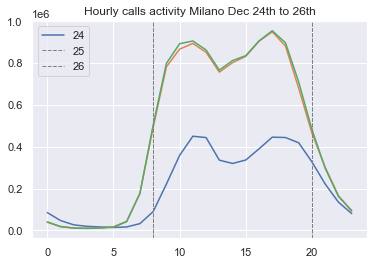

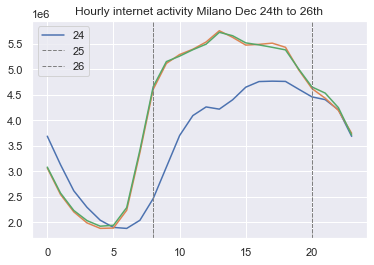

In [403]:
make_histograms(milano_nov, "Milano Nov 26th to 28th")
make_histograms(milano_dec, "Milano Dec 24th to 26th")

## 5. Find correlation between user communication activity and different weather conditions (e.g. rain, snow etc.) in Milan and Trentino.

Milano weather dataset columns:

1. Timestamp: timestamp value with the following format: YYYYMMDDHHmm;

2. Square id: id of a given square of Milan/Trentino GRID;

3. Intensity: intensity value of the precipitation. It is a value between 0 and 3;

4. Coverage: percentage value of the quadrant covered by the precipitation;

5. Type: type of the precipitation. It is a value between 0 and 2.

Trentino weather dataset columns:

1. Timestamp: timestamp value with the following format: YYYYMMDDHHmm;

2. Square id: id of a given square of Milan/Trentino GRID;

3. Intensity: intensity value of the precipitation. It is a value between 0 and 18.


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/MeteoMilano_01-11-13_01-01-14.csv

Parsing completed. Parsed 100 lines in 0.015827 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/MeteoMilano_01-11-13_01-01-14.csv

Parsing completed. Parsed 33316 lines in 0.016665 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/precipitation-trentino.csv

Parsing completed. Parsed 100 lines in 0.290014 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2489903 lines. Lines per second: 5.05141e+06

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/precipitation-trentino.csv

Parsing completed. Parsed 3489417 lines in 0.587584 secs.

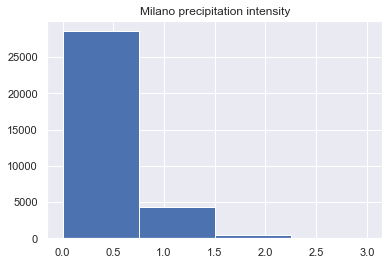

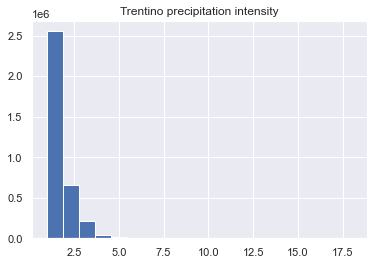

3
18


In [383]:
# Set paths to weather files
milano_weather_path = 'data/MeteoMilano_01-11-13_01-01-14.csv'
trentino_weather_path = 'data/precipitation-trentino.csv'

# Read weather files
milano_weather = SFrame.read_csv(milano_weather_path, sep=",", header=None)
trentino_weather = SFrame.read_csv(trentino_weather_path, sep=",", header=None)

# Rename columns of the weather SFrames
milano_weather = milano_weather.rename({'X1':'timestamp', 'X2':'sqrtID', 'X3':"intensity", "X4":"coverage", "X5":"type"})
trentino_weather = trentino_weather.rename({'X1': 'timestamp', 'X2':'sqrtID', 'X3':"intensity"})

# Make intensity histograms to see intensity distribution in Milan and Trentino.
# Milan and Trentino precipitation intensity has different scales.
# Milan scale is 0-4 and Trentino 0-18.
plt.hist(milano_weather["intensity"], bins=4)
plt.title("Milano precipitation intensity")
plt.show()
plt.hist(trentino_weather["intensity"], bins=19)
plt.title("Trentino precipitation intensity")
plt.show()

    
#clear_weather = gl.SFrame()
#rain_weather = gl.SFrame()
#snow_weather = gl.SFrame()

#clear_weather = weather.filter_by(0, 'type')
#rain_weather = weather.filter_by(1, 'type')
#snow_weather = weather.filter_by(2, 'type')

#clear_weather = clear_weather.join(trento_usage, on='timestamp', how='inner')
#rain_weather = rain_weather.join(trento_usage, on='timestamp', how='inner')
#snow_weather = snow_weather.join(trento_usage, on='timestamp', how='inner')

#milano_weather.print_rows(num_rows=5)
#trentino_weather.print_rows(num_rows=5)

In [349]:
import seaborn as sns
sns.set()
sns.distplot(clear['total'], kde=False)
sns.distplot(rain['total'], kde=False)
sns.distplot(snow['total'], kde=False)
plt.legend(['Clear', 'Rain', 'Snow'])
plt.axvline(0, color="k", linestyle="--");
plt.show()

NameError: name 'clear' is not defined

## 6. Plot the heatmap of user telecommunication activity for both Milan and Trentino. Do you observe any shift in communication pattern of users between day and night? (A typical day time is between 8AM to 8PM)

In [407]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_trento_nov = glob2.glob("data/trento_telecom_nov/*")

# Use create_telecom_SFrame to read paths and join the files within given dates
milano_nov_tele = create_hourly_telecom_SFrame(data_paths_milano_nov, 26, 28)
trento_nov_tele = create_hourly_telecom_SFrame(data_paths_trento_nov, 26, 28)

# Print first 5 rows
milano_nov_tele.print_rows(num_rows=5)
trento_nov_tele.print_rows(num_rows=5)


#trento_busy_hours = dec_day_con(trento_time)
#trento_time = gl.SFrame(trento_telecom)
#trento_plots.show(columns=['time_interval', 'total'],view='Heat Map', x='time_interval', y='total')

Time to run function was 90 seconds
Time to run function was 91 seconds
+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  26 |  0   | 3081805.3777902406 | 41192.73183245969  |
|  26 |  1   | 2572701.7786852866 | 17706.48807058413  |
|  26 |  2   | 2231849.134087163  | 11778.291443263028 |
|  26 |  3   | 2032399.1755711264 | 10178.701211725705 |
|  26 |  4   | 1922521.8709400026 | 11383.318199818335 |
+-----+------+--------------------+--------------------+
[72 rows x 4 columns]

+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  26 |  0   | 3081805.377790242  | 41192.73183245976  |
|  26 |  1   | 2572701.778685296  | 17706.488070584106 |
|  26 |  2   | 2231849.134087153  | 11778.291443263033 |
|  26 |  3   | 2032399.1755711301 | 10178.70121172

## 7. Investigate and plot the correlation between air quality and weather (temperature, sunshine, precipitation, etc.).

In [389]:
# Define function to read and join all Milano pollution data files
def milano_pollution(paths):
    # Initialize empty SFrame
    #result_df = pd.DataFrame(columns = ["SquareID", "Time", "country_code"])
    results_sf = SFrame({'X1':[],'X2':[], 'X3':[]})
    results_sf["X1"] = results_sf["X1"].astype(int)
    results_sf["X2"] = results_sf["X2"].astype(str)
    results_sf["X3"] = results_sf["X3"].astype(int)
    
    # Add pollution data one by one to results_sf
    for path in paths:
        # Read file
        sf_tmp = SFrame.read_csv(path, sep=",", header=None)
        # Set column types
        sf_tmp["X1"] = sf_tmp["X1"].astype(int)
        sf_tmp["X2"] = sf_tmp["X2"].astype(str)
        sf_tmp["X3"] = sf_tmp["X3"].astype(int)
        # Append sf_tmp to results_sf
        results_sf = results_sf.append(sf_tmp)
    # Rename columns
    sf_tmp = sf_tmp.rename({'X1': 'xxx1', 'X2':'time', 'X3':"xxx3"})
    # Return SFrame with all Milano pollution data
    return results_sf

# Define path to folder of Milano pollution data files
milano_pollution_paths = glob2.glob("data/milano_pollution_data/*")

# Run milano_pollution function and get all Milano pollution data
milano_pollution = milano_pollution(milano_pollution_paths)

milano_pollution

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6956.csv

Parsing completed. Parsed 54 lines in 0.005741 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6956.csv

Parsing completed. Parsed 54 lines in 0.006037 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5722.csv

Parsing completed. Parsed 100 lines in 0.006257 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5722.csv

Parsing completed. Parsed 1353 lines in 0.005939 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6372.csv

Parsing completed. Parsed 100 lines in 0.006311 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6372.csv

Parsing completed. Parsed 1460 lines in 0.00759 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6366.csv

Parsing completed. Parsed 100 lines in 0.00624 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6366.csv

Parsing completed. Parsed 1312 lines in 0.006564 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5531.csv

Parsing completed. Parsed 100 lines in 0.006462 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5531.csv

Parsing completed. Parsed 1312 lines in 0.006311 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5725.csv

Parsing completed. Parsed 100 lines in 0.007446 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5725.csv

Parsing completed. Parsed 1312 lines in 0.006063 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10278.csv

Parsing completed. Parsed 100 lines in 0.006652 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10278.csv

Parsing completed. Parsed 1459 lines in 0.006032 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10279.csv

Parsing completed. Parsed 100 lines in 0.006382 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10279.csv

Parsing completed. Parsed 1461 lines in 0.006108 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5542.csv

Parsing completed. Parsed 100 lines in 0.006593 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5542.csv

Parsing completed. Parsed 1462 lines in 0.006619 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6328.csv

Parsing completed. Parsed 100 lines in 0.006225 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6328.csv

Parsing completed. Parsed 1460 lines in 0.006442 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6062.csv

Parsing completed. Parsed 100 lines in 0.0059 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6062.csv

Parsing completed. Parsed 1461 lines in 0.00673 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20020.csv

Parsing completed. Parsed 100 lines in 0.005662 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20020.csv

Parsing completed. Parsed 743 lines in 0.005441 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10280.csv

Parsing completed. Parsed 100 lines in 0.006104 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10280.csv

Parsing completed. Parsed 1352 lines in 0.005895 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5552.csv

Parsing completed. Parsed 100 lines in 0.006069 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5552.csv

Parsing completed. Parsed 1462 lines in 0.006021 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5550.csv

Parsing completed. Parsed 100 lines in 0.005755 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5550.csv

Parsing completed. Parsed 1062 lines in 0.005666 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10282.csv

Parsing completed. Parsed 100 lines in 0.005833 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10282.csv

Parsing completed. Parsed 1461 lines in 0.005715 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10283.csv

Parsing completed. Parsed 61 lines in 0.00546 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10283.csv

Parsing completed. Parsed 61 lines in 0.005602 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5551.csv

Parsing completed. Parsed 100 lines in 0.006138 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5551.csv

Parsing completed. Parsed 1462 lines in 0.005959 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10320.csv

Parsing completed. Parsed 59 lines in 0.005535 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10320.csv

Parsing completed. Parsed 59 lines in 0.00579 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17126.csv

Parsing completed. Parsed 100 lines in 0.007953 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17126.csv

Parsing completed. Parsed 1461 lines in 0.006271 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17127.csv

Parsing completed. Parsed 100 lines in 0.006526 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17127.csv

Parsing completed. Parsed 1484 lines in 0.006194 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20004.csv

Parsing completed. Parsed 100 lines in 0.006086 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20004.csv

Parsing completed. Parsed 692 lines in 0.006247 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6320.csv

Parsing completed. Parsed 100 lines in 0.007691 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6320.csv

Parsing completed. Parsed 1462 lines in 0.006214 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10273.csv

Parsing completed. Parsed 61 lines in 0.007438 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10273.csv

Parsing completed. Parsed 61 lines in 0.0056 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5827.csv

Parsing completed. Parsed 100 lines in 0.008173 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5827.csv

Parsing completed. Parsed 1461 lines in 0.005773 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20005.csv

Parsing completed. Parsed 88 lines in 0.005864 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20005.csv

Parsing completed. Parsed 88 lines in 0.005743 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6057.csv

Parsing completed. Parsed 100 lines in 0.005978 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6057.csv

Parsing completed. Parsed 1462 lines in 0.005756 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5823.csv

Parsing completed. Parsed 100 lines in 0.006067 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5823.csv

Parsing completed. Parsed 1462 lines in 0.005902 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5834.csv

Parsing completed. Parsed 100 lines in 0.006122 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5834.csv

Parsing completed. Parsed 1462 lines in 0.006122 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17122.csv

Parsing completed. Parsed 59 lines in 0.005733 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17122.csv

Parsing completed. Parsed 59 lines in 0.005549 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6354.csv

Parsing completed. Parsed 100 lines in 0.00608 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6354.csv

Parsing completed. Parsed 1462 lines in 0.005901 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6340.csv

Parsing completed. Parsed 100 lines in 0.007645 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6340.csv

Parsing completed. Parsed 1061 lines in 0.005883 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5841.csv

Parsing completed. Parsed 100 lines in 0.00621 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5841.csv

Parsing completed. Parsed 1461 lines in 0.006642 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5504.csv

Parsing completed. Parsed 100 lines in 0.006088 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5504.csv

Parsing completed. Parsed 1461 lines in 0.006124 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5506.csv

Parsing completed. Parsed 100 lines in 0.006024 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5506.csv

Parsing completed. Parsed 1460 lines in 0.006157 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6344.csv

Parsing completed. Parsed 100 lines in 0.006219 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6344.csv

Parsing completed. Parsed 1461 lines in 0.006249 secs.

X1,X2,X3
6956,2013/11/01,41
6956,2013/11/02,55
6956,2013/11/03,42
6956,2013/11/04,32
6956,2013/11/05,35
6956,2013/11/06,35
6956,2013/11/07,67
6956,2013/11/08,76
6956,2013/11/09,43
6956,2013/11/10,26


# Answers:
### In the answers I have used dates 26-28th November and 24-26th December

### Read telecom data

In [54]:
# Create function to join multiple files, filter by date, and join to single dataframe    
def create_telecom_SFrame(paths, start_date, end_date):
    # Measure time how long it takes. Set start time.
    start = time.time()
    
    # Filter paths by start_date and end_date
    # Path example: sms-call-internet-mi-2013-12-01.txt
    wanted_paths = []
    for path in data_paths:
        date = int(path[-6:-4])
        if (date <= end_date) and (date >= start_date):
            wanted_paths.append(path)
    
    # Read the files and append dataframes to result_df
    result_df = pd.DataFrame(columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "Internet_Traffic"])
    for path in wanted_paths:
        df = pd.read_csv(path, sep="\t", header=None)
        #df = df.fillna(0)
        df.columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "Internet_Traffic"]
        result_df= result_df.append(df)
    
    # Convert Pandas dataframe to SFrame
    result_SFrame = SFrame(data=result_df)
    
    # Add UTC_time columns. Running this row takes about 5mins.
    #result_df["UTCtime"] = result_df["Time"].apply(lambda timestamp: arrow.get(timestamp).format('MMM Do YYYY HH:mm'))
    
    # Print time how long it took
    end = time.time()
    print("Time to run function was", round(end - start), "seconds")

    # Return results
    return result_SFrame


1.2874603271484375e-05
6.030048131942749
197.31782484054565
197.31798195838928


SquareID,Time,country_code,SMSin,SMSout,call_in
1,1385420400000,0,0.05701250935247165,nan,nan
1,1385420400000,39,0.1864510916887049,0.2161631361639904,0.10920185950874473
1,1385421000000,0,0.003574620210998875,nan,nan
1,1385421000000,39,0.21670190728429012,0.22027652749528906,0.02730046487718618
1,1385421600000,39,0.13417624316013174,0.2190279885100893,0.052274848528573205
1,1385421600000,46,nan,nan,nan
1,1385422200000,39,0.0017873101054994376,0.010723860632996627,nan
1,1385422800000,0,0.05460092975437236,nan,nan
1,1385422800000,39,0.0825256641241584,0.057012509352471666,0.08190139463155853
1,1385423400000,0,0.0261374242642866,nan,nan


In [ ]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_milano_dec = glob2.glob("data/milano_telecom_dec/*")
data_paths_trento_nov = glob2.glob("data/trento_telecom_nov/*")
data_paths_trento_dec = glob2.glob("data/trento_telecom_dec/*")

# Use create_telecom_SFrame to read paths and join the folders with given date
milano_nov = create_telecom_SFrame(data_paths_milano_nov, 26, 28)
#milano_dec = create_telecom_SFrame(data_paths_milano_dec, 24, 26)
#trento_nov = create_telecom_SFrame(data_paths_trento_nov, 26, 28)
#trento_dec = create_telecom_SFrame(data_paths_trento_dec, 26, 28)

milano_nov

In [17]:
df["time2"] = df["Time"].apply(lambda timestamp: arrow.get(timestamp).format('MMM Do YYYY HH:mm'))

In [18]:
df

,SquareID,Time,country_code,SMSin,SMSout,call_in,call_out,Internet_Traffic,time2
0,1,1385247600000,0.0,0.108663,0.000000,0.000000,0.000000,0.000000,Nov 23rd 2013 23:00
1,1,1385247600000,39.0,0.347389,0.163350,0.187614,0.159151,10.037029,Nov 23rd 2013 23:00
2,1,1385248200000,0.0,0.081901,0.000000,0.000000,0.000000,0.000000,Nov 23rd 2013 23:10
3,1,1385248200000,39.0,0.321790,0.239889,0.053438,0.137127,9.153816,Nov 23rd 2013 23:10
4,1,1385248800000,39.0,0.161477,0.136588,0.080738,0.186451,8.714426,Nov 23rd 2013 23:20
...,...,...,...,...,...,...,...,...,...
4548400,9999,1385332200000,0.0,0.000000,0.000000,0.000000,0.171990,0.000000,Nov 24th 2013 22:30
4548401,9999,1385332200000,39.0,0.827417,0.505940,0.092566,0.427531,22.566848,Nov 24th 2013 22:30
4548402,9999,1385332800000,39.0,0.000000,0.349524,0.171990,0.000000,28.150824,Nov 24th 2013 22:40
4548403,9999,1385333400000,0.0,0.085995,0.000000,0.000000,0.000000,0.000000,Nov 24th 2013 22:50
